In [1]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
K_VALUE = 21
ISOFORM_READ_FILE = "chr11_transcriptome.fasta"
TRANSCRIPT_READ_FILE = "reads.fasta"

## Part 1
Create the index given a isoform read file

In [3]:
def get_back_index(isoform_filename, k_mer_length):
    isoform_file = open(isoform_filename, 'r')

    back_index = dict()

    for isoform in SeqIO.parse(isoform_file, "fasta"):
        seq = isoform.seq
        seq_str = str(seq)
        seq_len = len(seq_str) 
        for i in range(0, seq_len - k_mer_length + 1):
            k_mer = seq_str[i:i+k_mer_length]
            if k_mer in back_index:
                back_index[k_mer].add(isoform.id)
            else:
                back_index[k_mer] = {isoform.id}
        
        
    isoform_file.close()
    return back_index

In [4]:
back_index = get_back_index(ISOFORM_READ_FILE, K_VALUE)

## Part 2
Get the equivalence sets from each read given a transcript reads file. Keeping the k-mer length the same, this block below can be run multiple times with different transcript read files after running the code from Part 1, since the index can be reused again and again.

In [5]:
# create a function such that given the reverse maps, we can find 
# the equivalence class for the 
def get_equivalence_class(isoform_dict, transcript, k_mer_length) -> set | None:
    transcript_str = str(transcript) 
    transcript_len = len(transcript_str)
    
    equivalence_class = None
    # take intersection over all the equivalence sets for each k-mer
    for i in range(0, transcript_len - k_mer_length + 1):
        k_mer = transcript_str[i:i+k_mer_length]

        # check if the k_mer exists in the dictionary
        if k_mer in isoform_dict:
            isoforms = isoform_dict[k_mer]
        else:
            isoforms = set()

        if not equivalence_class: # first iteration, no set to intersect on yet
            equivalence_class = isoforms
        else: 
            equivalence_class = equivalence_class.intersection(isoforms)
    return equivalence_class


In [6]:
def get_equivalence_class_mappings(transcript_file, back_index, k_mer_length):
    transcript_file = open(transcript_file, 'r')

    equivalence_class_mappings = dict()

    for transcript in SeqIO.parse(transcript_file, "fasta"):
        seq = transcript.seq
        # first work with the forward strand
        canonical_strand_classes = get_equivalence_class(back_index, seq, k_mer_length)
        if canonical_strand_classes is None: 
            break 
        # get the classes for the reverse strand
        reverse_complement_classes = get_equivalence_class(back_index, seq.reverse_complement(), k_mer_length)
        if reverse_complement_classes is None:
            break
        """
        Current implementation for difference in forward and reverse
        strands is to take the union
        """
        combined_classes = canonical_strand_classes.union(reverse_complement_classes)
        
        hashable_combined_classes = frozenset(combined_classes)
        if hashable_combined_classes in equivalence_class_mappings:
            equivalence_class_mappings[hashable_combined_classes] += 1
        else:
            equivalence_class_mappings[hashable_combined_classes] = 1
    transcript_file.close()
    return equivalence_class_mappings

In [7]:
# sort by length of the equivalent sets
equivalence_class_mappings = get_equivalence_class_mappings(TRANSCRIPT_READ_FILE, back_index, K_VALUE)
temp_dict_list = sorted(list(equivalence_class_mappings.items()), key = lambda key : len(key[0]))

equivalence_class_mappings = {ele[0] : ele[1] for ele in temp_dict_list}

In [8]:
# dictionary to map equivalence class size to the frequency of appearance
equivalence_class_size_frequency = dict()

In [9]:
data = list()
for equivalence_class, count in equivalence_class_mappings.items():
    class_len = len(equivalence_class)
    
    # maintain data to output into the csv
    data.append([count, class_len, list(equivalence_class)])

    # maintain dictionary to get the map of length of equivalence class to the number of transcripts 
    # that align with an equivalence class of that size
    if class_len in equivalence_class_size_frequency:
        equivalence_class_size_frequency[class_len] += count
    else:
        equivalence_class_size_frequency[class_len] = count

output_df = pd.DataFrame(data, columns=["counts", "num items in equivalence classe", "isoforms in equivalence class"])

with open("output.csv", 'w') as output_file:
    output_file.write(output_df.to_csv(index=False))


## Part 3
Output the frequency of the size of the equivalence sets.

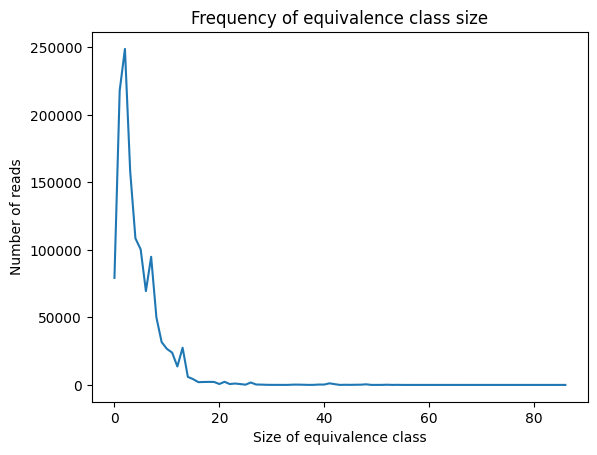

In [10]:
# get a plot of size to frequency
plt.plot(equivalence_class_size_frequency.keys(), equivalence_class_size_frequency.values())
plt.ylabel("Number of reads")
plt.xlabel("Size of equivalence class")
plt.title("Frequency of equivalence class size")
plt.show()

## Part 4
Run a simulation over different k-mer lengths to see which one gives the least nulls

In [11]:
k_mer_lengths = list(range(21,37))
k_mer_lengths

[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

In [12]:
kmer_length_to_num_null = dict()
for k_mer_length in k_mer_lengths:
    back_index = get_back_index(ISOFORM_READ_FILE, k_mer_length)
    equivalence_class_mappings = get_equivalence_class_mappings(TRANSCRIPT_READ_FILE, back_index, k_mer_length)
    nulls = equivalence_class_mappings[frozenset({})]
    kmer_length_to_num_null[k_mer_length] = nulls
    print(f"Finish iteration for k-mer length: {k_mer_length}. Found {nulls} nulls.")

Finish iteration for k-mer length: 21. Found 79266 nulls.
Finish iteration for k-mer length: 22. Found 81119 nulls.
Finish iteration for k-mer length: 23. Found 82706 nulls.
Finish iteration for k-mer length: 24. Found 84174 nulls.
Finish iteration for k-mer length: 25. Found 85525 nulls.
Finish iteration for k-mer length: 26. Found 86808 nulls.
Finish iteration for k-mer length: 27. Found 88115 nulls.
Finish iteration for k-mer length: 28. Found 89327 nulls.
Finish iteration for k-mer length: 29. Found 90462 nulls.
Finish iteration for k-mer length: 30. Found 91840 nulls.
Finish iteration for k-mer length: 31. Found 93097 nulls.
Finish iteration for k-mer length: 32. Found 94413 nulls.
Finish iteration for k-mer length: 33. Found 95582 nulls.
Finish iteration for k-mer length: 34. Found 97076 nulls.
Finish iteration for k-mer length: 35. Found 98466 nulls.
Finish iteration for k-mer length: 36. Found 99897 nulls.


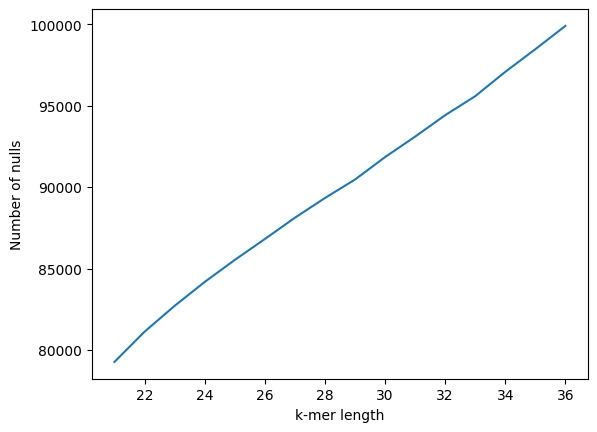

In [13]:
plt.plot(kmer_length_to_num_null.keys(), kmer_length_to_num_null.values())
plt.xlabel("k-mer length")
plt.ylabel("Number of nulls")
plt.show()